# Exploratory / Descriptive Data Mining
# Grouping books from Google Books Library Project

## Details
### Data
24 books about Antiquity (both classical and secondary literature)
### Format
Books composed of a HTML document for each page

## Import libraries

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import codecs
import re
import copy
import collections

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, WordPunctTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift, estimate_bandwidth
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import scale, StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, leaves_list, cut_tree

import operator

%matplotlib inline

## File paths

In [3]:
html_files_path = os.getcwd() + '/data/html_files'
text_files_path = os.getcwd() + '/data/text_files'

## Book titles

In [3]:
book_titles = {
    'gap_-C0BAAAAQAAJ' : 'Dictionary of Greek and Roman geography'.upper(),
    'gap_2X5KAAAAYAAJ' : 'The History of Tacitus (V5of8)'.upper(),
    'gap_9ksIAAAAQAAJ' : 'The history of the peloponnesian war (V2)'.upper(),
    'gap_aLcWAAAAQAAJ' : 'The history of the decline and fall of the Roman Empire (V1)'.upper(),
    'gap_Bdw_AAAAYAAJ' : 'The history of Rome (V1)'.upper(),
    'gap_CnnUAAAAMAAJ' : 'THE WHOLE GENUINE WORKS OF FLAVIUS JOSEPHUS (V2of4)'.upper(),
    'gap_CSEUAAAAYAAJ' : 'The history of the decline and fall of the Roman Empire (V3)'.upper(),
    'gap_DhULAAAAYAAJ' : 'THE DESCRIPTION OF GREECE, BY PAUSANIAS'.upper(),
    'gap_dIkBAAAAQAAJ' : 'THE HISTORY OF ROME (V3)'.upper(),
    'gap_DqQNAAAAYAAJ' : 'LIVY (V3)'.upper(),
    'gap_fnAMAAAAYAAJ' : 'The history of the peloponnesian war (V1)'.upper(),
    'gap_GIt0HMhqjRgC' : 'HISTORY OF THE DECLINE AND FALL THE ROMAN EMPIRE (V4)'.upper(),
    'gap_IlUMAQAAMAAJ' : 'HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V2)'.upper(),
    'gap_MEoWAAAAYAAJ' : 'THE HISTORICAL ANNALS of Cornelius TACITUS (V1of3)'.upper(),
    'gap_m_6B1DkImIoC' : 'TITUS LIVIUS ROMAN HISTORY'.upper(),
    'gap_ogsNAAAAIAAJ' : 'THE WORKS OF JOSEPHUS (V4of4)'.upper(),
    'gap_pX5KAAAAYAAJ' : 'THE works of Cornelius TACITUS (V4of8)'.upper(),
    'gap_RqMNAAAAYAAJ' : 'LIVY (V5)'.upper(),
    'gap_TgpMAAAAYAAJ' : 'THE GENUINE WORKS OF FLAVIUS JOSEPHUS (V1of2)'.upper(),
    'gap_udEIAAAAQAAJ' : 'THE FIRST AND THIRTY-THIRD BOOKS OF PLINY\'S NATURAL HISTORY'.upper(),
    'gap_VPENAAAAQAAJ' : 'The history of the decline and fall of the Roman Empire (V5)'.upper(),
    'gap_WORMAAAAYAAJ' : 'THE histories of Caius Cornelius TACITUS'.upper(),
    'gap_XmqHlMECi6kC' : 'HISTORY OF THE DECLINE AND FALL of THE ROMAN EMPIRE (V6)'.upper(),
    'gap_y-AvAAAAYAAJ' : 'THE WORKS OF FLAVIUS JOSEPHUS (V3of4)'.upper(),
}

## Convert HTML files to raw text files and save in disk

In [ ]:
for i,folder in enumerate( os.listdir(html_files_path) ):
    book_folder_path = html_files_path + '/' + folder
    output_file_path = text_files_path + "/" + folder + '.txt'
    output_file = codecs.open(output_file_path, "a+", encoding='utf-8')
    print 'Processing:',i,folder
    for filename in sorted(os.listdir(book_folder_path)):
        file_path = book_folder_path + '/' + filename
        text = BeautifulSoup(codecs.open(file_path, 'r', encoding='utf-8').read()).body.get_text()
        output_file.write(text)
    output_file.close

## Load text files

In [5]:
def load_books_text():
    books = []
    books_names = []
    for i,book in enumerate( os.listdir(text_files_path) ):
        print 'Processing:',i,book
        book_path = text_files_path + '/' + book
        book_name = book.split('.')[0]
        books.append( codecs.open(book_path, 'r', encoding='utf-8').read() )
        books_names.append(book_name)
    return books, books_names

In [6]:
books, books_names = load_books_text()

Processing: 0 gap_VPENAAAAQAAJ.txt
Processing: 1 gap_fnAMAAAAYAAJ.txt
Processing: 2 gap_MEoWAAAAYAAJ.txt
Processing: 3 gap_CnnUAAAAMAAJ.txt
Processing: 4 gap_dIkBAAAAQAAJ.txt
Processing: 5 gap_-C0BAAAAQAAJ.txt
Processing: 6 gap_m_6B1DkImIoC.txt
Processing: 7 gap_ogsNAAAAIAAJ.txt
Processing: 8 gap_CSEUAAAAYAAJ.txt
Processing: 9 gap_GIt0HMhqjRgC.txt
Processing: 10 gap_aLcWAAAAQAAJ.txt
Processing: 11 gap_Bdw_AAAAYAAJ.txt
Processing: 12 gap_WORMAAAAYAAJ.txt
Processing: 13 gap_XmqHlMECi6kC.txt
Processing: 14 gap_IlUMAQAAMAAJ.txt
Processing: 15 gap_pX5KAAAAYAAJ.txt
Processing: 16 gap_udEIAAAAQAAJ.txt
Processing: 17 gap_DqQNAAAAYAAJ.txt
Processing: 18 gap_9ksIAAAAQAAJ.txt
Processing: 19 gap_DhULAAAAYAAJ.txt
Processing: 20 gap_TgpMAAAAYAAJ.txt
Processing: 21 gap_y-AvAAAAYAAJ.txt
Processing: 22 gap_2X5KAAAAYAAJ.txt
Processing: 23 gap_RqMNAAAAYAAJ.txt


## Preprocessing

### Options

In [7]:
# Cleaning pattern (Remove numbers, keep words)
word_pattern = re.compile("^[^\d\W]+$")

# Choose stemmer
stemmer = SnowballStemmer('english')

### Tokenizer

In [8]:
def custom_tokenizer(text):
    tokens = word_tokenize(text)
#     tokens = WordPunctTokenizer().tokenize(text)

    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

### Preprocessor

In [9]:
def custom_preprocessor(text):
    return text

## Feature Extraction

### Options

In [121]:
vectorizer_options = dict(
    min_df = 0.1,
    max_df = 0.7,
    stop_words = 'english',
#     token_pattern = "^[^\d\W]+$",
    tokenizer = custom_tokenizer,
#     preprocessor = custom_preprocessor,
    ngram_range = (1, 1),
)

# vectorizer = CountVectorizer(**vectorizer_options)
vectorizer = TfidfVectorizer(**vectorizer_options)

In [122]:
vectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.7, max_features=None, min_df=0.1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function custom_tokenizer at 0x7f9b8b6f6de8>,
        use_idf=True, vocabulary=None)

In [123]:
def extract_features(documents):
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix

In [124]:
tfidf_matrix = extract_features(books)

In [113]:
terms = vectorizer.get_feature_names()

## Clustering

### Plot functions

#### Plot Clusters

In [125]:
def plot_cluster_labels2(labels, words=None):
    clusters = list(zip( [book_titles[b] for b in books_names], labels))
    clusters.sort(key=operator.itemgetter(1))
    
    title_labels = {}
    for title, label in clusters:
        title_labels.setdefault(label, []).append(title)
    for x in title_labels:
        print 'Cluster:',x
        if words != None:
            print 'Words:', ', '.join([ terms[i] for i in words[x]])
        print 'Books:'
        for i,y in enumerate(title_labels[x]):
            print (title_labels[x][i])
        print 

def plot_cluster_labels(clusters):
    title_labels = {}
    for title, label in clusters:
        title_labels.setdefault(label, []).append(title)
    for x in title_labels:
        print (x)
        for i,y in enumerate(title_labels[x]):
            print (title_labels[x][i])
        print 

#### Plot dendrogram

In [126]:
def plot_dendrogram(lm,labels,method=None):
    if method: method = ' - ' + method
    plt.figure(figsize=(25, 20))
    plt.title('Hierarchical Clustering Dendrogram - ' + method)
    plt.xlabel('books')
    plt.ylabel('distance')
    dendrogram(
        lm,
        orientation='left',
#         leaf_rotation=90.,  # rotates the x axis labels
#         leaf_font_size=12.,  # font size for the x axis labels
        labels=labels
    )
    plt.show()
#     plt.tight_layout()


#### Scatter Plot

In [127]:
def plot_scatter(mds_pos,clusters):
    df = pd.DataFrame(dict(x=mds_pos[:, 0], y=mds_pos[:, 1], label=clusters)) 
    groups = df.groupby('label')
#     unique_labels = np.unique(clusters)
#     colors=[np.random.rand(3,1) for i in unique_labels]
    colors = ['#0ec27f','#2b1bed','#d9749a','#13ed1f','#ca6b2c','#ca74da','#56f5df']
    plt.figure(figsize=(20, 20))
    for name,group in groups: 
        plt.scatter(group.x, group.y, c=colors[name], s=200)
    for i,bname in enumerate(books_names):
        plt.annotate(book_titles[bname], (mds_pos[:, 0][i],mds_pos[:, 1][i]), horizontalalignment='center', fontsize=20, wrap=True)
    plt.show()

### Hierarchical Agglomerative Clustering

#### $1^{st}$ Solution (Scikit-learn, AgglomerativeClustering)

In [128]:
model = AgglomerativeClustering(linkage='average', n_clusters=3)
cluster_labels = model.fit_predict(tfidf_matrix.toarray())
book_labels = list(zip(books_names,cluster_labels))
book_labels

[('gap_VPENAAAAQAAJ', 0),
 ('gap_fnAMAAAAYAAJ', 1),
 ('gap_MEoWAAAAYAAJ', 0),
 ('gap_CnnUAAAAMAAJ', 0),
 ('gap_dIkBAAAAQAAJ', 2),
 ('gap_-C0BAAAAQAAJ', 0),
 ('gap_m_6B1DkImIoC', 2),
 ('gap_ogsNAAAAIAAJ', 0),
 ('gap_CSEUAAAAYAAJ', 0),
 ('gap_GIt0HMhqjRgC', 0),
 ('gap_aLcWAAAAQAAJ', 0),
 ('gap_Bdw_AAAAYAAJ', 2),
 ('gap_WORMAAAAYAAJ', 0),
 ('gap_XmqHlMECi6kC', 0),
 ('gap_IlUMAQAAMAAJ', 0),
 ('gap_pX5KAAAAYAAJ', 0),
 ('gap_udEIAAAAQAAJ', 0),
 ('gap_DqQNAAAAYAAJ', 2),
 ('gap_9ksIAAAAQAAJ', 1),
 ('gap_DhULAAAAYAAJ', 1),
 ('gap_TgpMAAAAYAAJ', 0),
 ('gap_y-AvAAAAYAAJ', 0),
 ('gap_2X5KAAAAYAAJ', 0),
 ('gap_RqMNAAAAYAAJ', 2)]

#### $2^{nd}$ Solution (Scipy, linkage)

In [129]:
linkage_metrics = ['euclidean','cosine']
linkage_methods_euclidean = ['centroid','median','ward']
linkage_methods = ['single','complete','average','weighted']# + linkage_methods_euclidean
linkgage_matrix = [ linkage(tfidf_matrix.toarray(), method=method, metric='cosine') for method in linkage_methods]

#### Options

In [130]:
selected_method = 0
selected_n_clusters = 8

In [131]:
cut_tree_result = list(zip( [book_titles[b] for b in books_names], [ x[0] for x in cut_tree(linkgage_matrix[selected_method],n_clusters=selected_n_clusters).tolist()]))
cut_tree_result.sort(key=operator.itemgetter(1))
plot_cluster_labels(cut_tree_result)

0
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V5)
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V3)
HISTORY OF THE DECLINE AND FALL THE ROMAN EMPIRE (V4)
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V1)
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V6)
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V2)
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY

1
THE HISTORY OF THE PELOPONNESIAN WAR (V1)
THE HISTORY OF THE PELOPONNESIAN WAR (V2)

2
THE HISTORICAL ANNALS OF CORNELIUS TACITUS (V1OF3)
THE HISTORIES OF CAIUS CORNELIUS TACITUS
THE WORKS OF CORNELIUS TACITUS (V4OF8)
THE HISTORY OF TACITUS (V5OF8)

3
THE WHOLE GENUINE WORKS OF FLAVIUS JOSEPHUS (V2OF4)
THE WORKS OF JOSEPHUS (V4OF4)
THE GENUINE WORKS OF FLAVIUS JOSEPHUS (V1OF2)
THE WORKS OF FLAVIUS JOSEPHUS (V3OF4)

4
THE HISTORY OF ROME (V3)

5
DICTIONARY OF GREEK AND ROMAN GEOGRAPHY

6
TITUS LIVIUS ROMAN HISTORY
THE HISTORY OF ROME (V1)
LIVY (V3)
LIVY (V5)

7
THE DESCRIPTION O

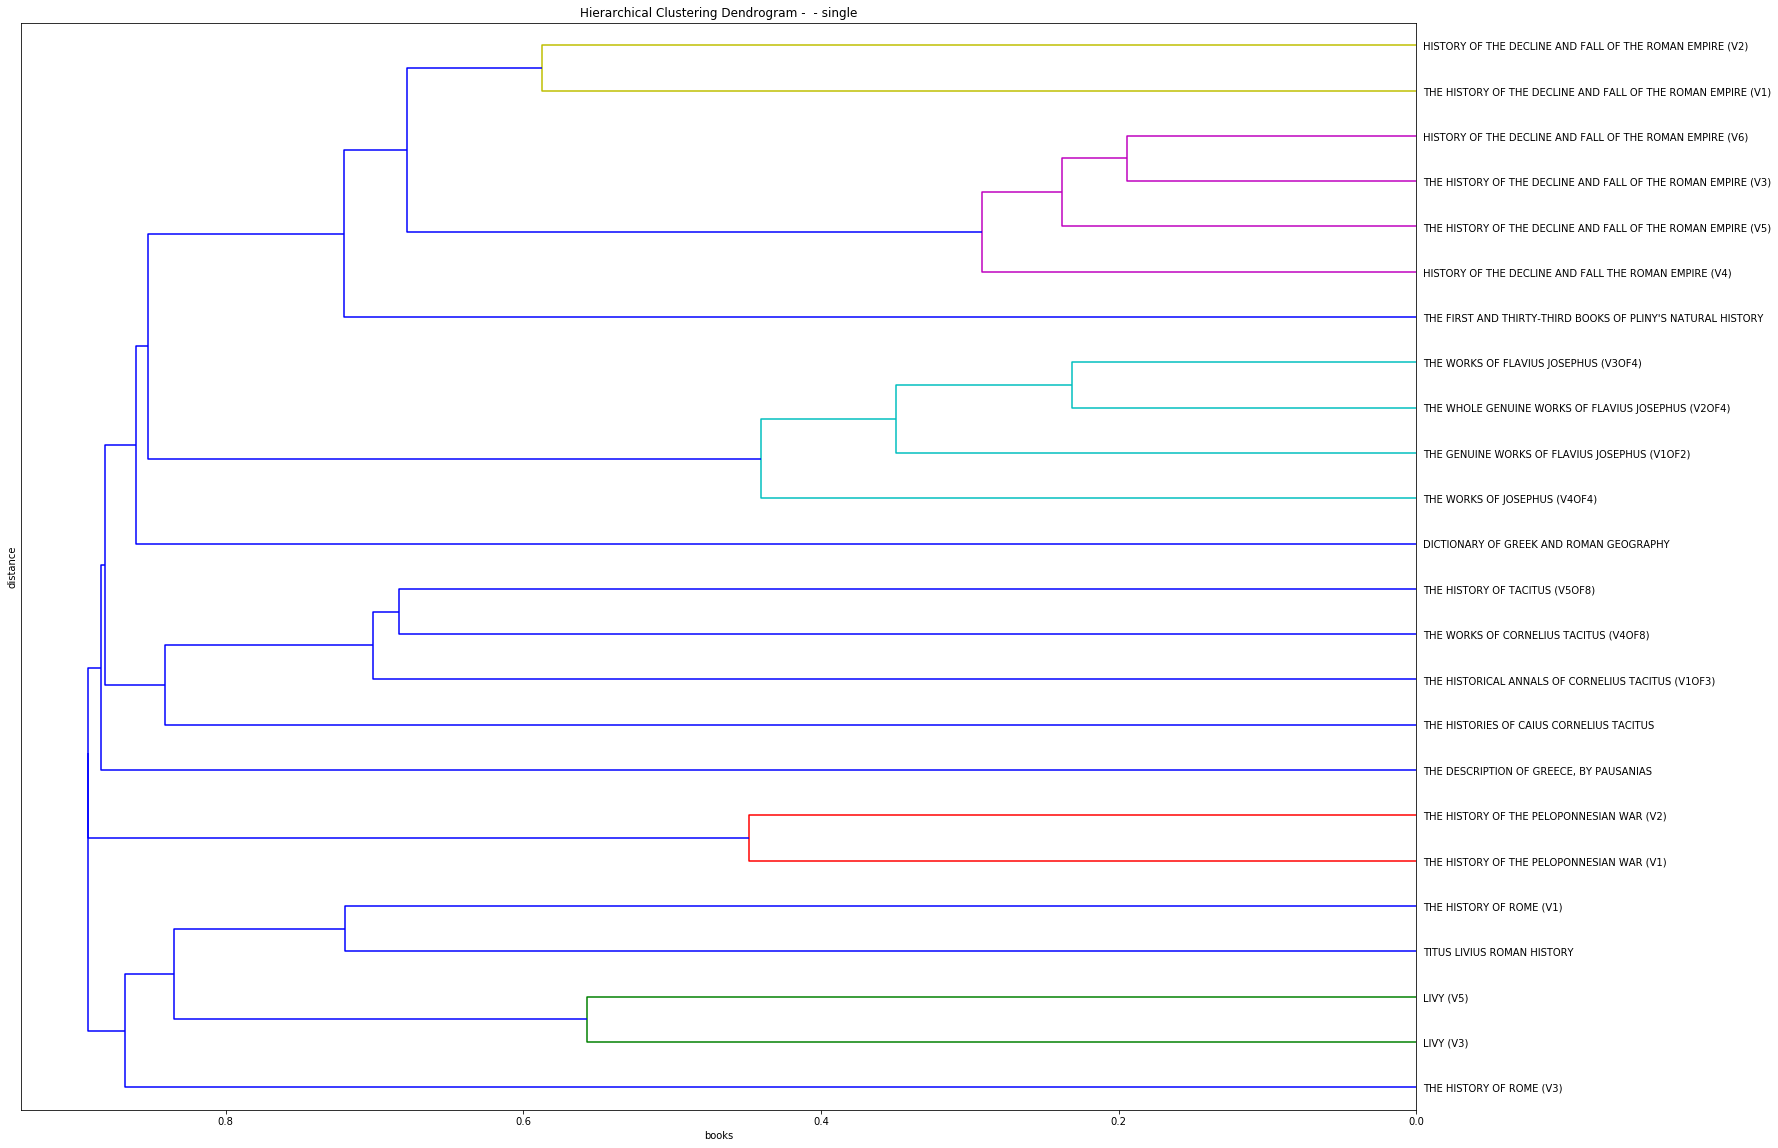

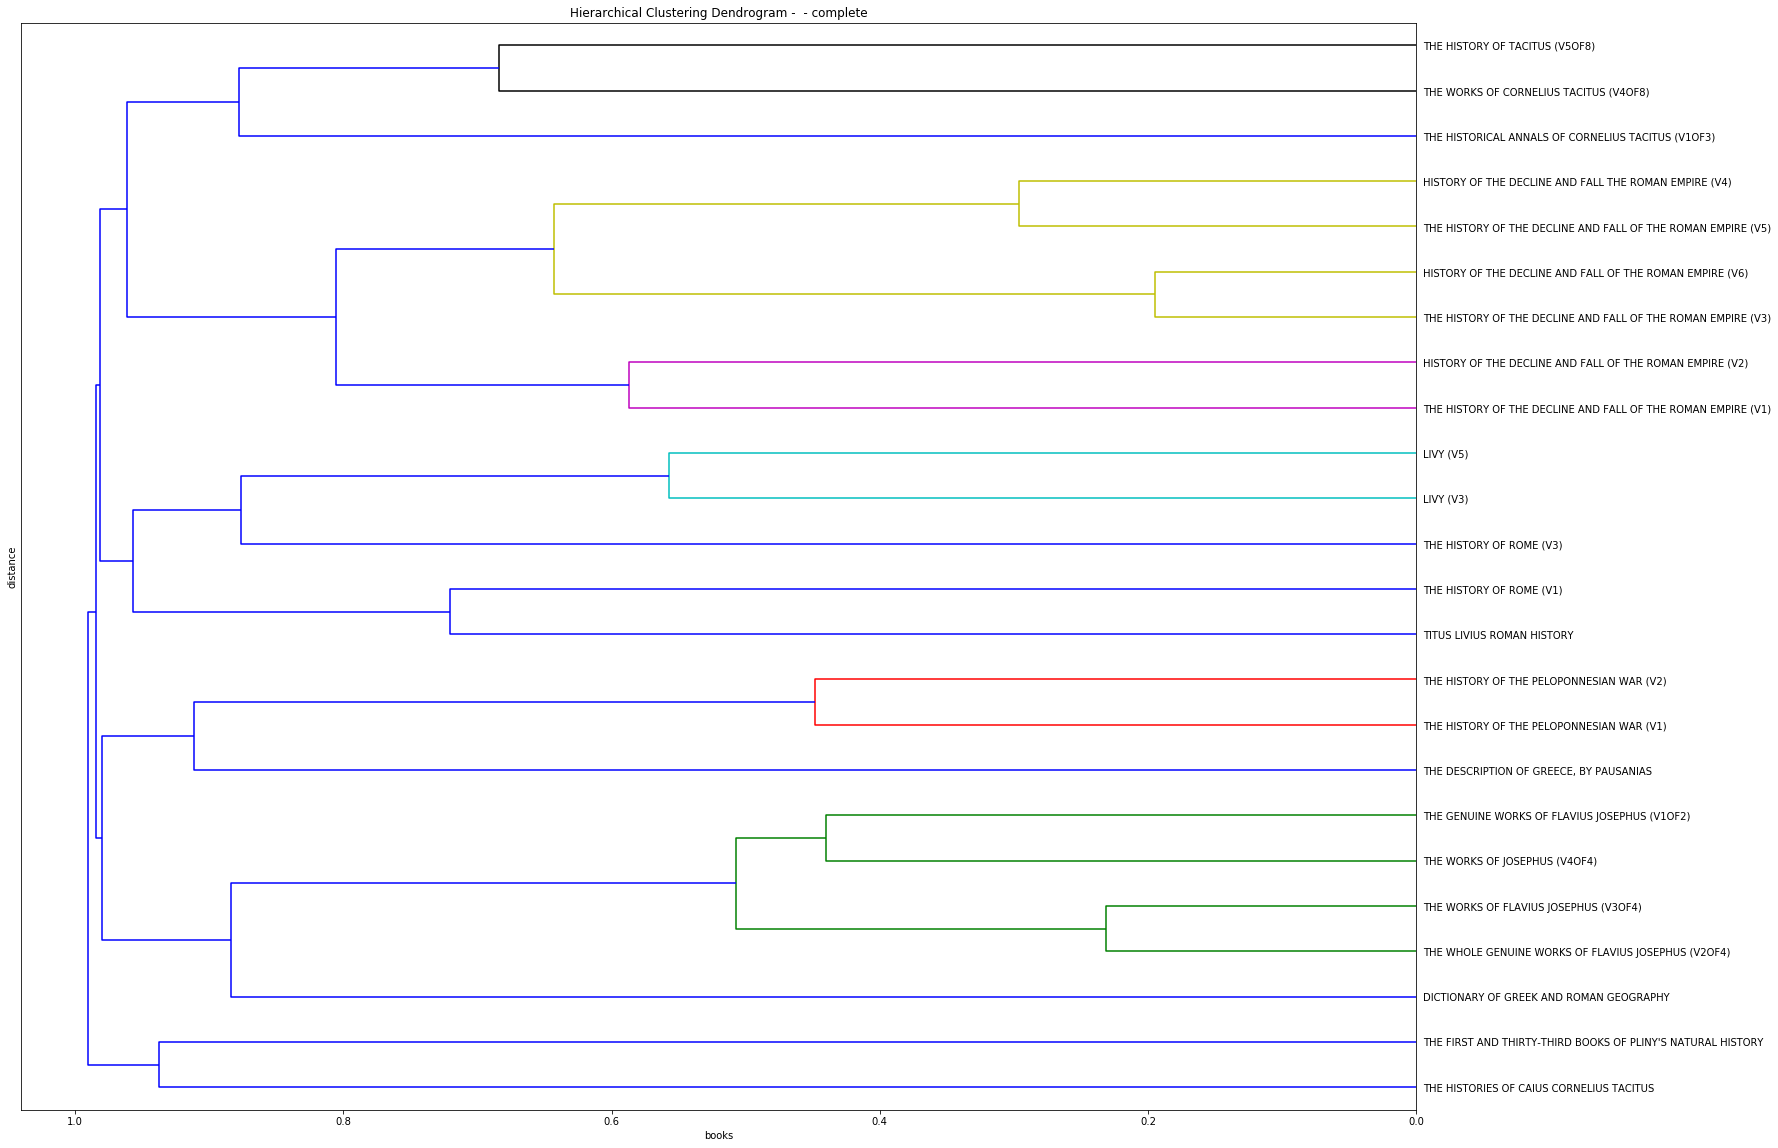

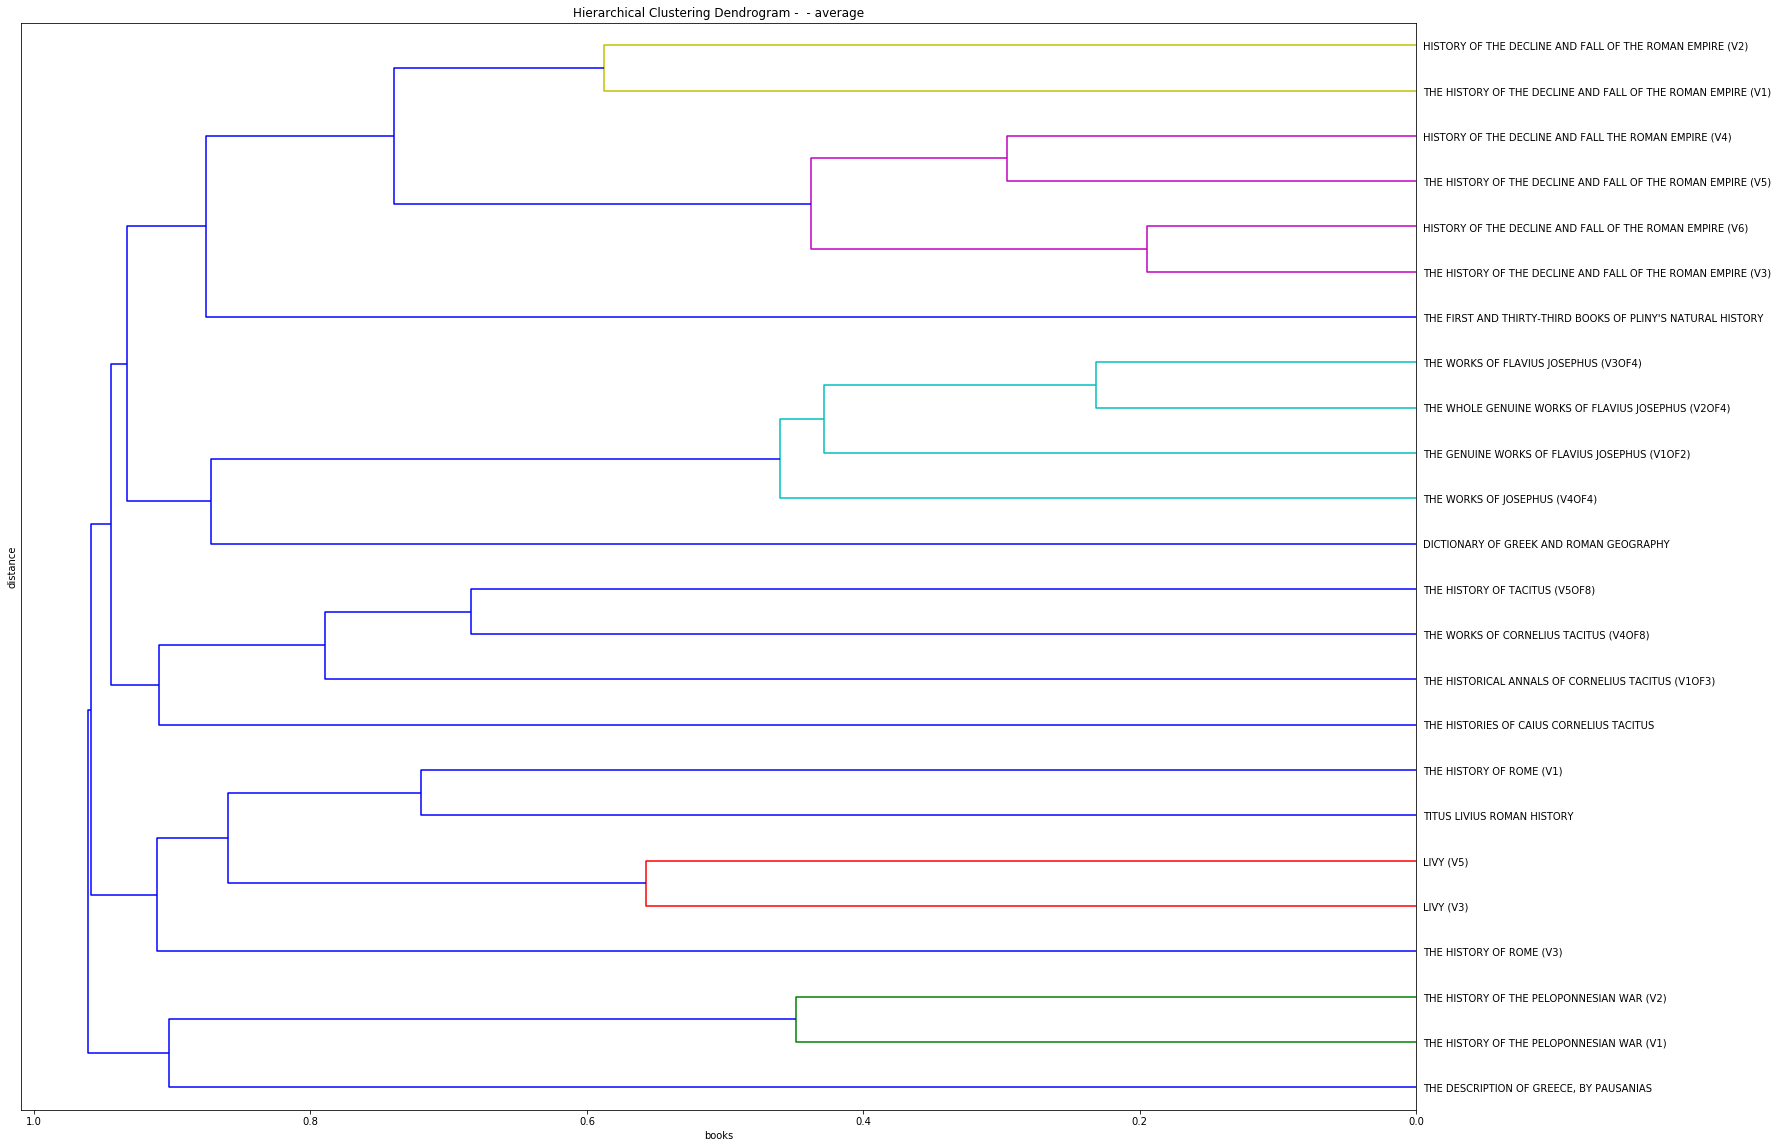

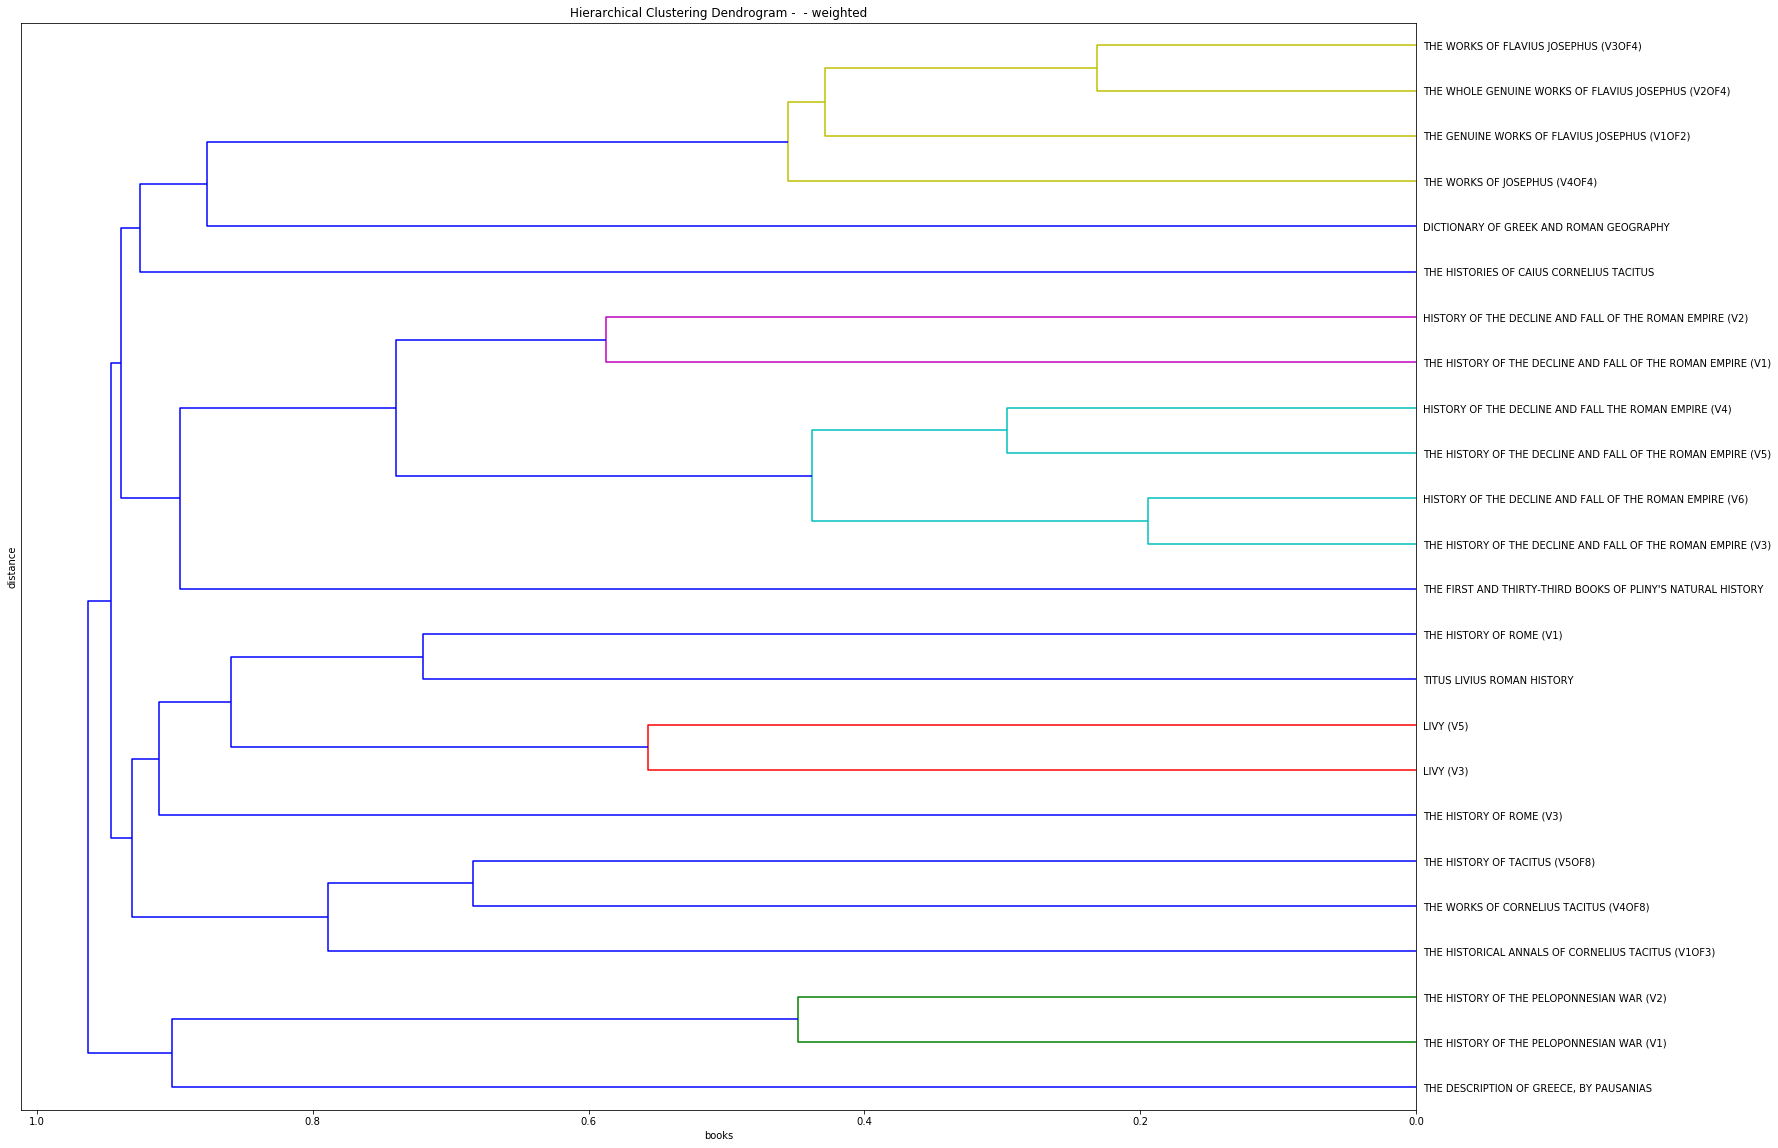

In [132]:
for i,method in enumerate(linkage_methods):
    plot_dendrogram(linkgage_matrix[i],[book_titles[b] for b in books_names], method)

### K-means Clustering

#### Options

In [133]:
num_clusters = 5

#### Clustering

In [134]:
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [135]:
clusters = list(zip( [book_titles[b] for b in books_names], km.labels_.tolist()))
clusters.sort(key=operator.itemgetter(1))
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
plot_cluster_labels2(km.labels_.tolist(),order_centroids[:, :10])

Cluster: 0
Words: justinian, lib, christian, constantinopl, constantin, belisarius, goth, mahomet, gothic, caliph
Books:
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V5)
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V3)
HISTORY OF THE DECLINE AND FALL THE ROMAN EMPIRE (V4)
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V1)
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V6)
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V2)

Cluster: 1
Words: peloponnesian, cf, sulla, fay, lacedaemonian, §, ■, syracusan, argiv, hath
Books:
THE HISTORY OF THE PELOPONNESIAN WAR (V1)
THE HISTORY OF ROME (V3)
DICTIONARY OF GREEK AND ROMAN GEOGRAPHY
THE HISTORIES OF CAIUS CORNELIUS TACITUS
THE HISTORY OF THE PELOPONNESIAN WAR (V2)
THE DESCRIPTION OF GREECE, BY PAUSANIAS

Cluster: 2
Words: germanicus, lib, section, otho, galba, vitellius, drusus, piso, silanus, suetonius
Books:
THE HISTORICAL ANNALS OF CORNELIUS TACITUS (V1OF3)
THE WORKS OF CORNELIUS TACITUS (V4OF8

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### Mean Shift Clustering

In [139]:
# Scale data
# scaled_data = tfidf_matrix.toarray()
# scaled_data = scale(tfidf_matrix.toarray())
scaled_data = StandardScaler().fit_transform(tfidf_matrix.toarray())

# estimate bandwidth for mean shift
# bandwidth = estimate_bandwidth(scaled_data, quantile=0.8)
# bandwidth = 1.12340120411136423772546777399838902056

bandwidth = 1.138
# bandwidth = 0.1

In [140]:
ms = MeanShift(bandwidth=bandwidth)
ms_result = ms.fit(scaled_data)

In [141]:
print '#Clusters:', len(np.unique(ms_result.labels_))
plot_cluster_labels2(ms_result.labels_)

#Clusters: 24
Cluster: 0
Books:
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V2)

Cluster: 1
Books:
THE HISTORY OF THE PELOPONNESIAN WAR (V1)

Cluster: 2
Books:
THE WORKS OF JOSEPHUS (V4OF4)

Cluster: 3
Books:
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V1)

Cluster: 4
Books:
THE WORKS OF CORNELIUS TACITUS (V4OF8)

Cluster: 5
Books:
HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V6)

Cluster: 6
Books:
THE WORKS OF FLAVIUS JOSEPHUS (V3OF4)

Cluster: 7
Books:
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V5)

Cluster: 8
Books:
THE FIRST AND THIRTY-THIRD BOOKS OF PLINY'S NATURAL HISTORY

Cluster: 9
Books:
THE HISTORICAL ANNALS OF CORNELIUS TACITUS (V1OF3)

Cluster: 10
Books:
THE GENUINE WORKS OF FLAVIUS JOSEPHUS (V1OF2)

Cluster: 11
Books:
THE HISTORIES OF CAIUS CORNELIUS TACITUS

Cluster: 12
Books:
DICTIONARY OF GREEK AND ROMAN GEOGRAPHY

Cluster: 13
Books:
THE HISTORY OF THE DECLINE AND FALL OF THE ROMAN EMPIRE (V3)

Cluster: 14
Books:
THE DESCRIPTI

## Visualising Data in 2D

### Multi-Dimensional Scaling

In [142]:
mds = MDS() # dissimilarity = euclidean
mds_pos = mds.fit_transform(tfidf_matrix.toarray())

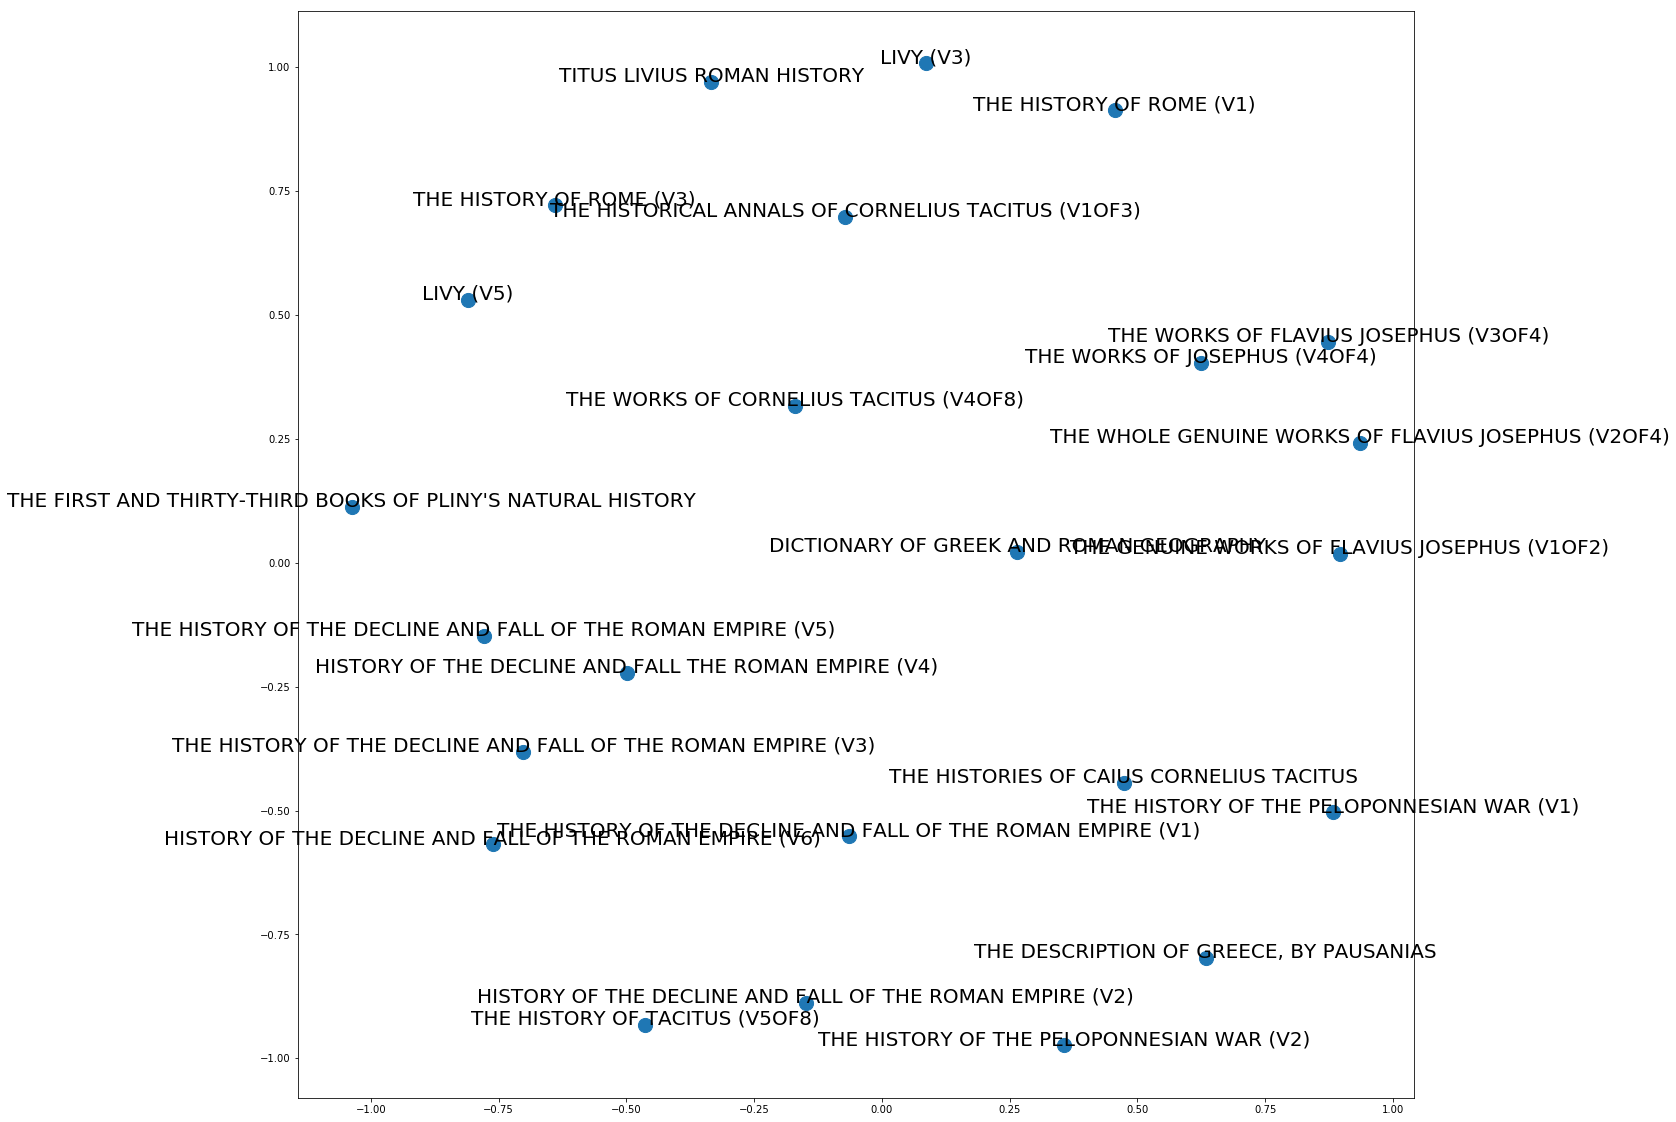

In [143]:
plt.figure(figsize=(20, 20))
plt.scatter(mds_pos[:, 0], mds_pos[:, 1], s=200)
for i,bname in enumerate(books_names):
    plt.annotate(book_titles[bname], (mds_pos[:, 0][i],mds_pos[:, 1][i]), horizontalalignment='center', fontsize=20, wrap=True)
plt.show()

#### K-means clustering and visualizing with MDS in a scatter plot

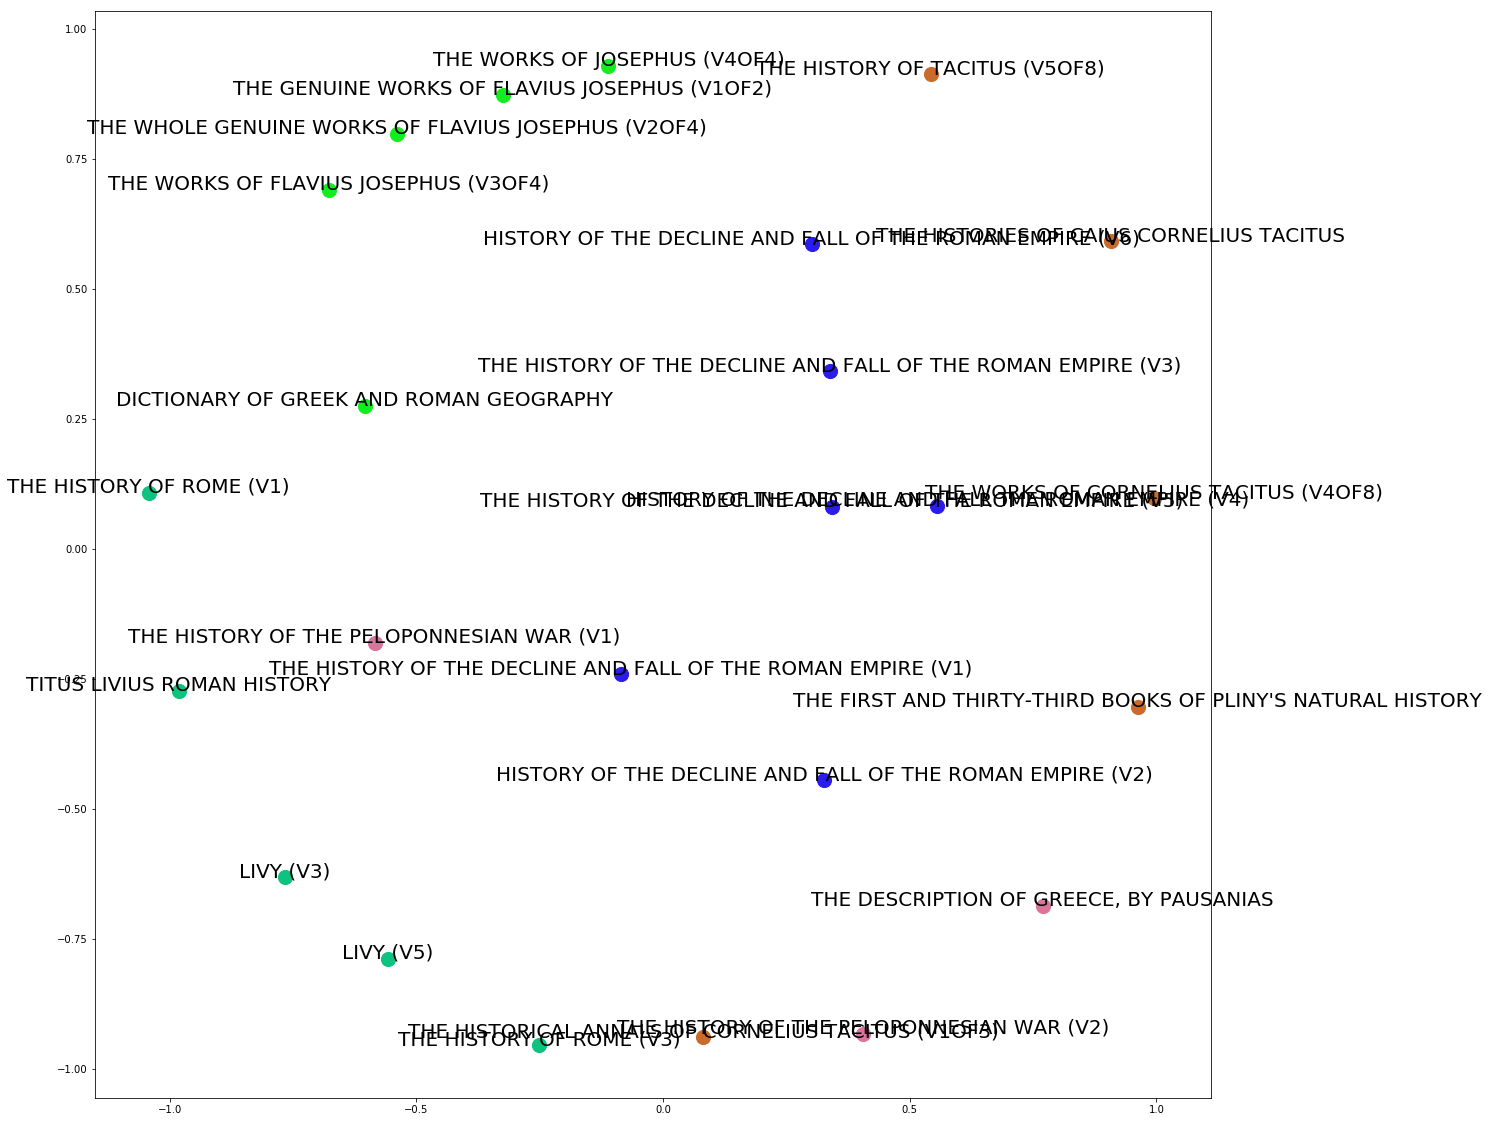

In [144]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
mds = MDS(random_state=1) # dissimilarity = euclidean
mds_pos = mds.fit_transform(tfidf_matrix.toarray())
plot_scatter(mds_pos,km.labels_.tolist())

### Principle Component Analysis

In [145]:
pca = PCA(n_components=2)
pca_pos = pca.fit_transform(tfidf_matrix.toarray())

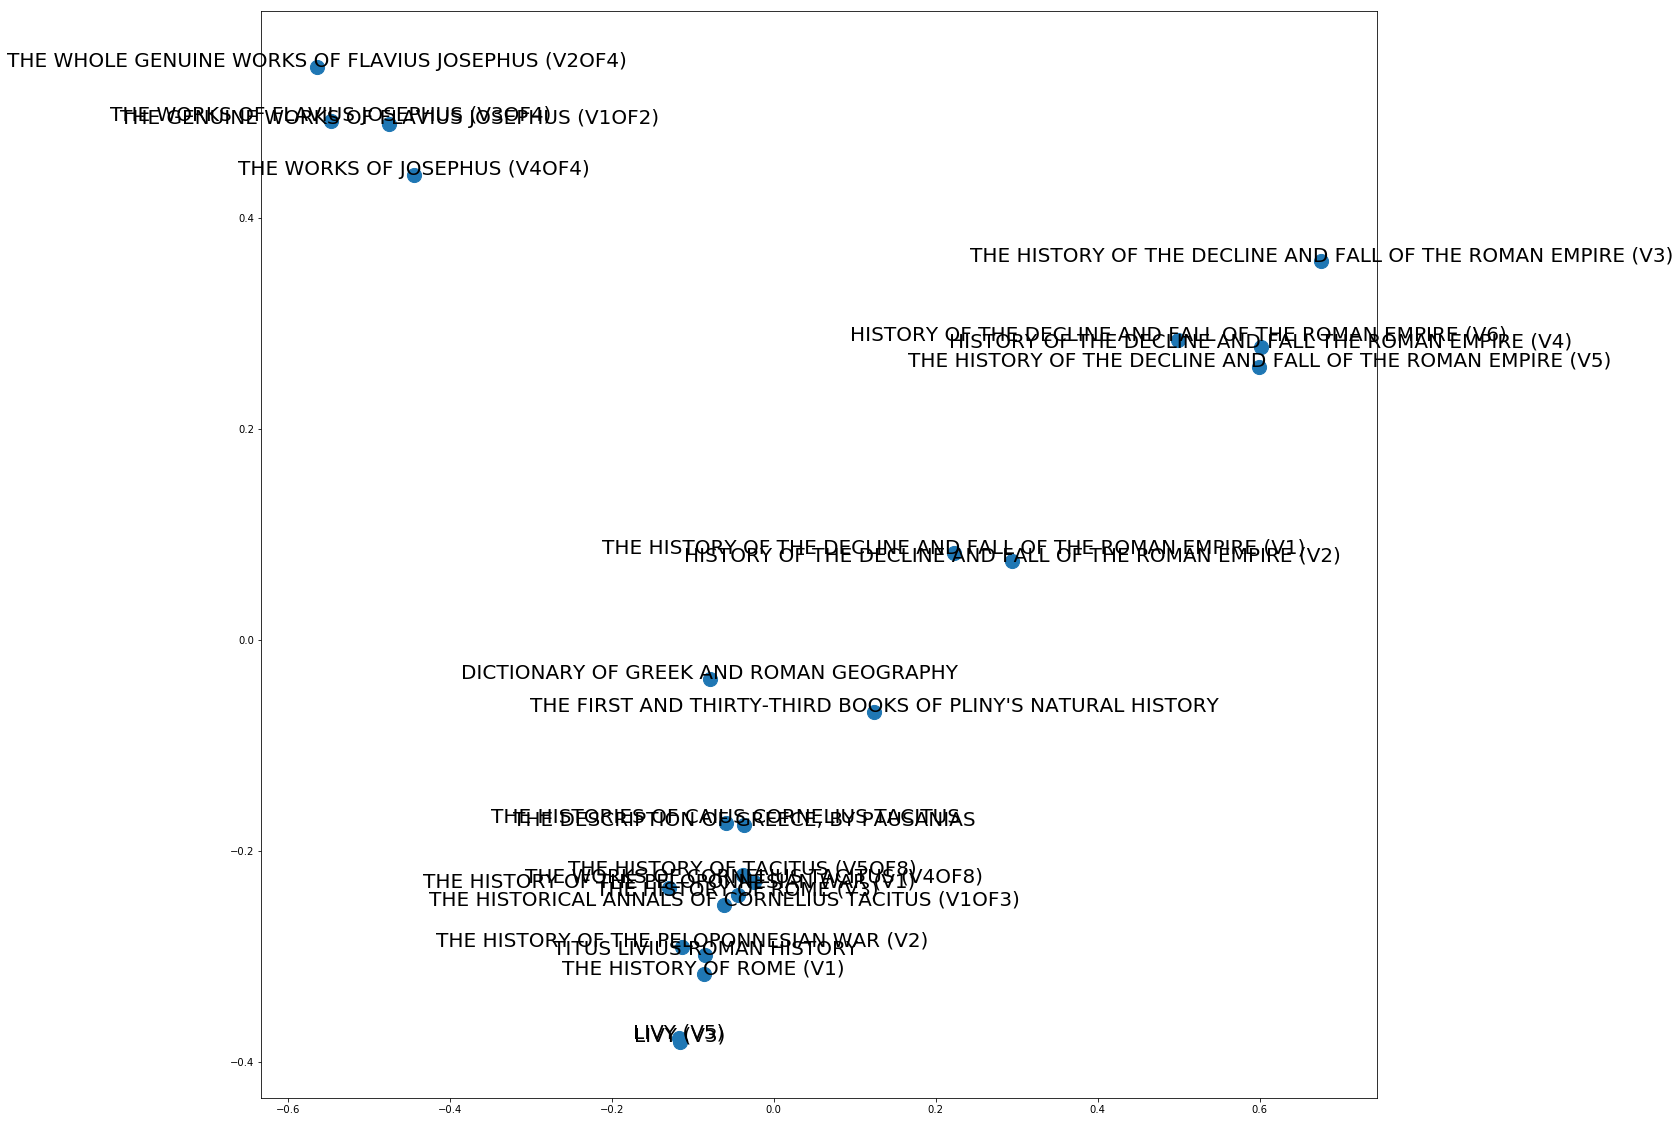

In [146]:
plt.figure(figsize=(20, 20))
plt.scatter(pca_pos[:, 0], pca_pos[:, 1], s=200)
for i,bname in enumerate(books_names):
    plt.annotate(book_titles[bname], (pca_pos[:, 0][i],pca_pos[:, 1][i]), horizontalalignment='center', fontsize=20, wrap=True)
plt.show()